# Integration_pancreas + label_transfer using scCobra

In [1]:
import scCobra
from scCobra import scCobra, label_transfer
from scCobra.plot import embedding
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sc.settings.verbosity = 3             
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=(3,3),frameon=True)
sc.logging.print_header()
plt.rcParams['axes.unicode_minus']=False

scanpy==1.6.1 anndata==0.7.5 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [3]:
sns.__version__

'0.10.1'

## Seeing the batch effect

The [pancreas](http://zhanglab.net/scalex-tutorial/pancreas.h5ad) data has been used in the [Seurat v3](https://www.sciencedirect.com/science/article/pii/S0092867419305598?via%3Dihub) and [Harmony](https://www.nature.com/articles/s41592-019-0619-0) paper.

On a unix system, you can uncomment and run the following to download the count matrix in its anndata format.

In [6]:
adata_raw=sc.read('pancreas.h5ad') 
adata_raw

AnnData object with n_obs × n_vars = 16401 × 14895
    obs: 'batch', 'celltype', 'disease', 'donor', 'library', 'protocol'

Inspect the batches contained in the dataset.

In [7]:
adata_raw.obs.batch.value_counts()

pancreas_indrop3       3605
pancreas_celseq2       3072
pancreas_smartseq2     2394
pancreas_indrop1       1937
pancreas_celseq        1728
pancreas_indrop2       1724
pancreas_indrop4       1303
pancreas_fluidigmc1     638
Name: batch, dtype: int64

The data processing procedure is according to the scanpy tutorial [[Preprocessing and clustering 3k PBMCs]](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html#Preprocessing-and-clustering-3k-PBMCs).

In [8]:
sc.pp.filter_cells(adata_raw, min_genes=600)
sc.pp.filter_genes(adata_raw, min_cells=3)
adata_raw = adata_raw[:, [gene for gene in adata_raw.var_names if not str(gene).startswith(tuple(['ERCC', 'MT-', 'mt-']))]]
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)
sc.pp.highly_variable_genes(adata_raw, min_mean=0.0125, max_mean=3, min_disp=0.5)    
adata_raw.raw = adata_raw
adata_raw = adata_raw[:, adata_raw.var.highly_variable]
sc.pp.scale(adata_raw, max_value=10)
sc.pp.pca(adata_raw)
sc.pp.neighbors(adata_raw)
sc.tl.umap(adata_raw)

filtered out 1124 cells that have less than 600 genes expressed
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


We observe a batch effect.

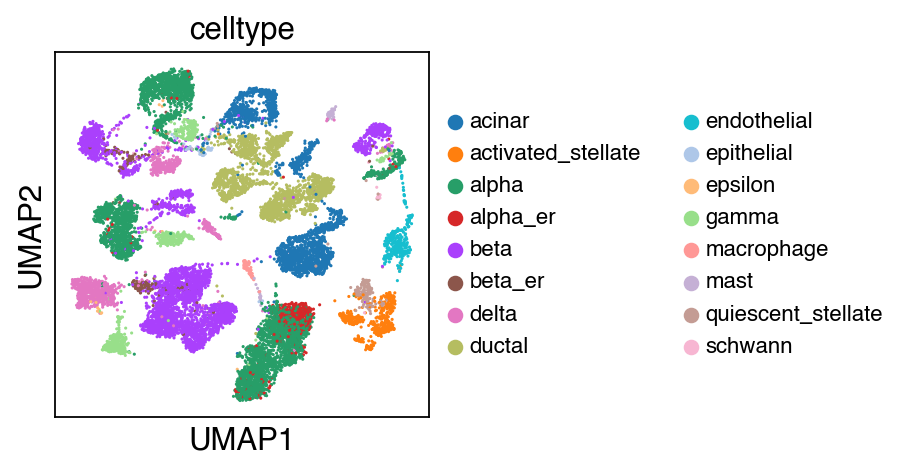

In [9]:
sc.pl.umap(adata_raw,color=['celltype'],legend_fontsize=10)

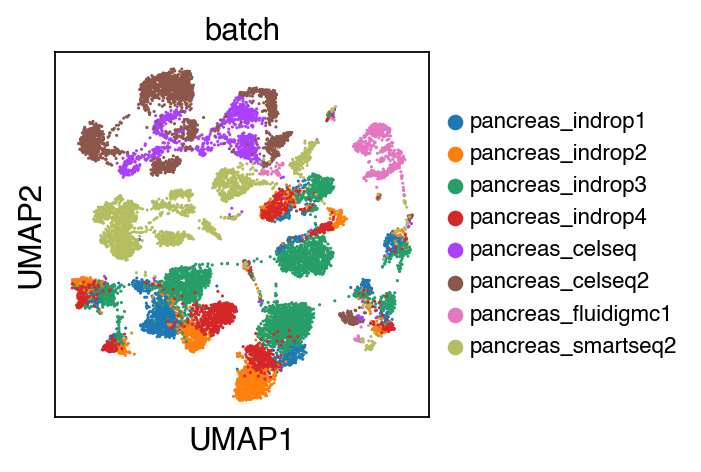

In [10]:
sc.pl.umap(adata_raw,color=['batch'],legend_fontsize=10)

In [11]:
adata_raw

AnnData object with n_obs × n_vars = 15277 × 2086
    obs: 'batch', 'celltype', 'disease', 'donor', 'library', 'protocol', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'celltype_colors', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Integrating data using scCobra

<div class="alert alert-info">

**Note**

Here we use GPU to speed up the calculation process, however, you can get the same level of performance only using cpu.    

</div>  

In [12]:
adata_ref=scCobra('pancreas.h5ad',batch_name='batch',min_features=600, min_cells=3, outdir='pancreas_output/',show=False,gpu=7)

2021-03-30 20:21:06,757 - root - INFO - Raw dataset shape: (16401, 14895)
2021-03-30 20:21:06,759 - root - INFO - Preprocessing
2021-03-30 20:21:06,785 - root - INFO - Filtering cells


filtered out 1124 cells that have less than 600 genes expressed


Trying to set attribute `.obs` of view, copying.
2021-03-30 20:21:09,107 - root - INFO - Filtering features
2021-03-30 20:21:10,607 - root - INFO - Normalizing total per cell


normalizing counts per cell
    finished (0:00:00)


2021-03-30 20:21:10,850 - root - INFO - Log1p transforming
2021-03-30 20:21:11,759 - root - INFO - Finding variable features


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


2021-03-30 20:21:17,003 - root - INFO - Batch specific maxabs scaling
2021-03-30 20:21:19,528 - root - INFO - Processed dataset shape: (15277, 2000)
2021-03-30 20:21:19,566 - root - INFO - model
VAE(
  (encoder): Encoder(
    (enc): NN(
      (net): ModuleList(
        (0): Block(
          (fc): Linear(in_features=2000, out_features=1024, bias=True)
          (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
        )
      )
    )
    (mu_enc): NN(
      (net): ModuleList(
        (0): Block(
          (fc): Linear(in_features=1024, out_features=10, bias=True)
        )
      )
    )
    (var_enc): NN(
      (net): ModuleList(
        (0): Block(
          (fc): Linear(in_features=1024, out_features=10, bias=True)
        )
      )
    )
  )
  (decoder): NN(
    (net): ModuleList(
      (0): Block(
        (fc): Linear(in_features=10, out_features=2000, bias=True)
        (norm): DSBatchNorm(
          (bns): ModuleList(

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


In [13]:
adata_ref

AnnData object with n_obs × n_vars = 15277 × 2000
    obs: 'batch', 'celltype', 'disease', 'donor', 'library', 'protocol', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'leiden', 'batch_colors', 'celltype_colors', 'leiden_colors'
    obsm: 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

While there seems to be some strong batch-effect in all cell types, scCobra can integrate them homogeneously.

In [14]:
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=(3,3),frameon=True)

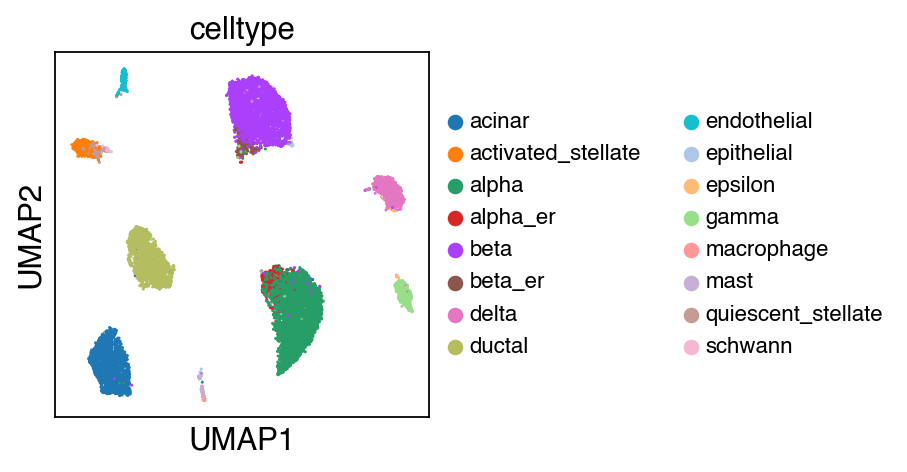

In [15]:
sc.pl.umap(adata_ref,color=['celltype'],legend_fontsize=10)

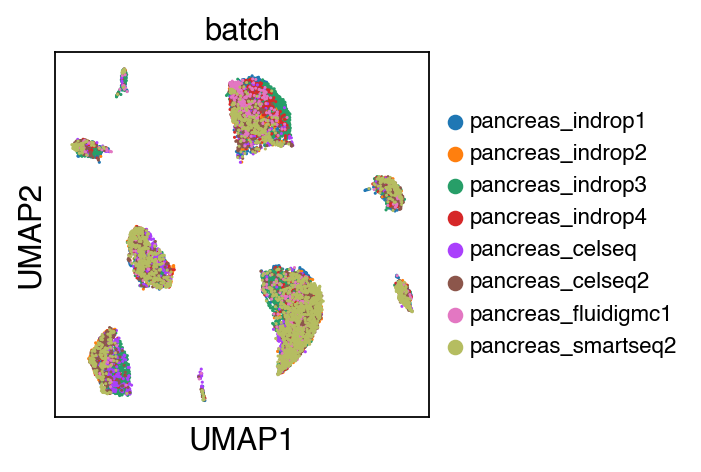

In [16]:
sc.pl.umap(adata_ref,color=['batch'],legend_fontsize=10)

The integrated data is stored as `adata.h5ad` in the output directory assigned by `outdir` parameter in scCobra function. 

## Mapping onto a reference batch using projection function

The [pancreas query](http://zhanglab.net/scalex-tutorial/pancreas_query.h5ad) data are available through the Gene Expression Omnibus under accession GSE114297, GSE81547 and GSE83139.

In [17]:
adata_query=sc.read('pancreas_query.h5ad') 
adata_query

AnnData object with n_obs × n_vars = 23963 × 31884
    obs: 'batch', 'celltype', 'disease', 'donor', 'protocol'

Inspect the batches contained in `adata_query`.

In [18]:
adata_query.obs.batch.value_counts()

pancreas_gse114297    20784
pancreas_gse81547      2544
pancreas_gse83139       635
Name: batch, dtype: int64

scCobra provides a projection function for mapping new data `adata_query` onto the reference batch `adata_ref`.

In [19]:
adata=scCobra('pancreas_query.h5ad',batch_name='batch',min_features=600, min_cells=3,
             outdir='pancreas_projection/', projection='pancreas_output/',show=False,gpu=0)

2021-03-30 20:31:47,177 - root - INFO - Raw dataset shape: (23963, 31884)
2021-03-30 20:31:47,177 - root - INFO - Raw dataset shape: (23963, 31884)
2021-03-30 20:31:47,180 - root - INFO - Preprocessing
2021-03-30 20:31:47,180 - root - INFO - Preprocessing
2021-03-30 20:31:47,236 - root - INFO - Filtering cells
2021-03-30 20:31:47,236 - root - INFO - Filtering cells


filtered out 219 cells that have less than 600 genes expressed


Trying to set attribute `.obs` of view, copying.
2021-03-30 20:31:49,744 - root - INFO - Filtering features
2021-03-30 20:31:49,744 - root - INFO - Filtering features
2021-03-30 20:31:51,094 - root - INFO - Normalizing total per cell
2021-03-30 20:31:51,094 - root - INFO - Normalizing total per cell


normalizing counts per cell
    finished (0:00:00)


2021-03-30 20:31:51,430 - root - INFO - Log1p transforming
2021-03-30 20:31:51,430 - root - INFO - Log1p transforming
2021-03-30 20:31:52,607 - root - INFO - Finding variable features
2021-03-30 20:31:52,607 - root - INFO - Finding variable features


There are 2000 gene in selected genes


2021-03-30 20:31:56,488 - root - INFO - Batch specific maxabs scaling
2021-03-30 20:31:56,488 - root - INFO - Batch specific maxabs scaling
2021-03-30 20:31:59,442 - root - INFO - Processed dataset shape: (23744, 2000)
2021-03-30 20:31:59,442 - root - INFO - Processed dataset shape: (23744, 2000)
2021-03-30 20:32:04,207 - root - INFO - Output dir: pancreas_projection//
2021-03-30 20:32:04,207 - root - INFO - Output dir: pancreas_projection//
... storing 'batch' as categorical
... storing 'celltype' as categorical
... storing 'disease' as categorical
... storing 'donor' as categorical
... storing 'library' as categorical
... storing 'protocol' as categorical
... storing 'leiden' as categorical
2021-03-30 20:32:08,411 - root - INFO - Plot umap
2021-03-30 20:32:08,411 - root - INFO - Plot umap


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:26)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:10)


Load integrated data `adata` that contained `adata_ref` and `adata_query`.

In [20]:
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=(3,3),frameon=True)

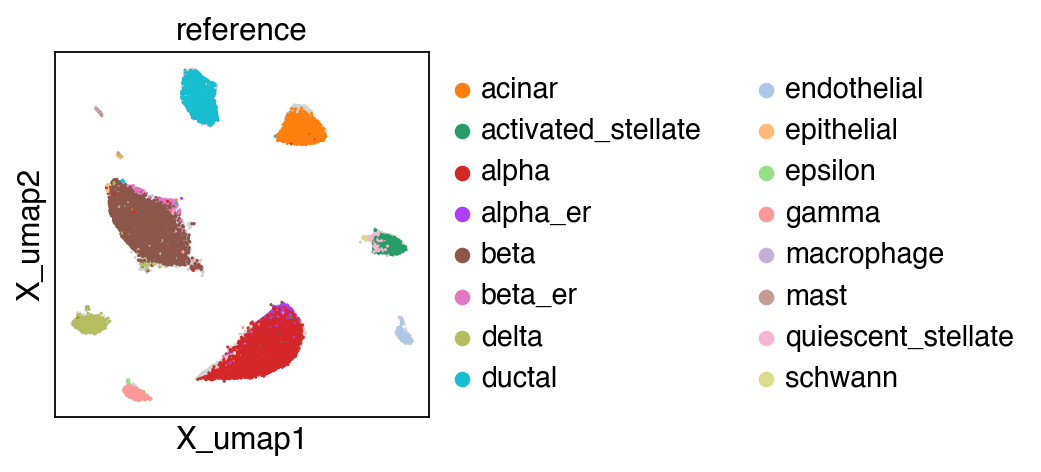

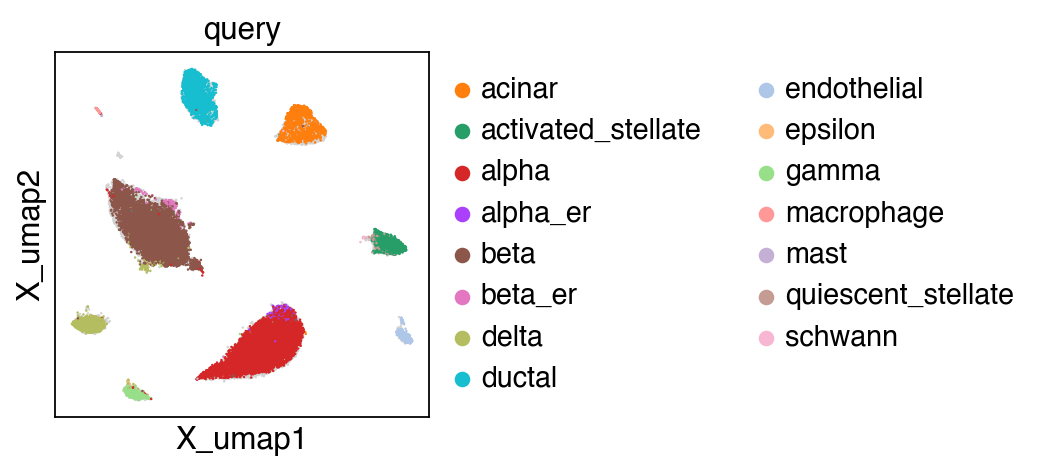

In [21]:
embedding(adata,groupby='projection')

In [22]:
adata

AnnData object with n_obs × n_vars = 39021 × 2000
    obs: 'batch', 'celltype', 'disease', 'donor', 'library', 'protocol', 'n_genes', 'leiden', 'projection'
    var: 'n_cells-reference', 'highly_variable-reference', 'means-reference', 'dispersions-reference', 'dispersions_norm-reference', 'highly_variable_nbatches-reference', 'highly_variable_intersection-reference'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

Inspect the batches contained in `adata`.

In [23]:
adata.obs.batch.value_counts()

pancreas_gse114297     20573
pancreas_indrop3        3605
pancreas_gse81547       2536
pancreas_celseq2        2440
pancreas_smartseq2      2394
pancreas_indrop1        1937
pancreas_indrop2        1724
pancreas_indrop4        1303
pancreas_celseq         1236
pancreas_fluidigmc1      638
pancreas_gse83139        635
Name: batch, dtype: int64

## Visualizing distributions across batches

Trying to set attribute `.uns` of view, copying.


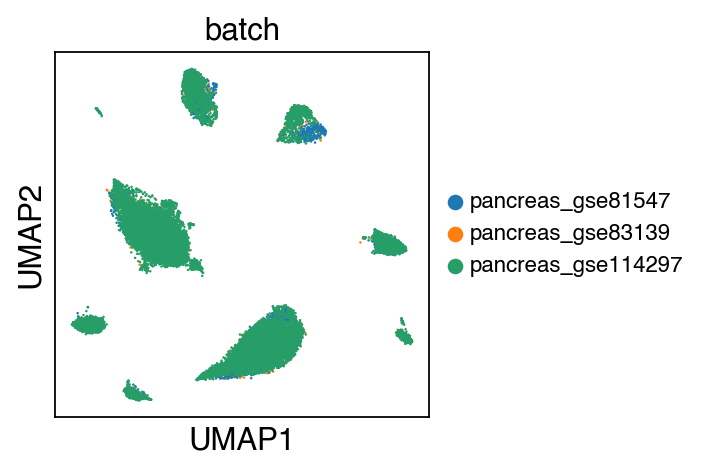

Trying to set attribute `.obs` of view, copying.


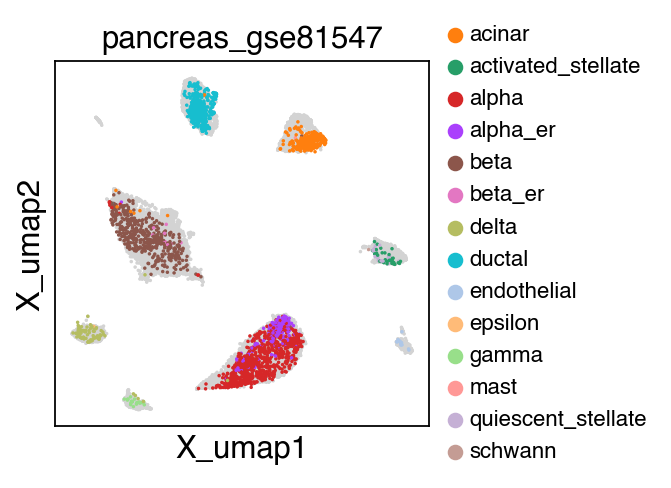

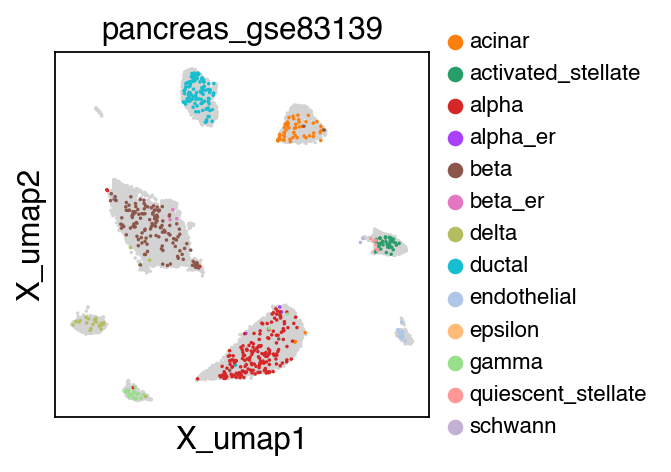

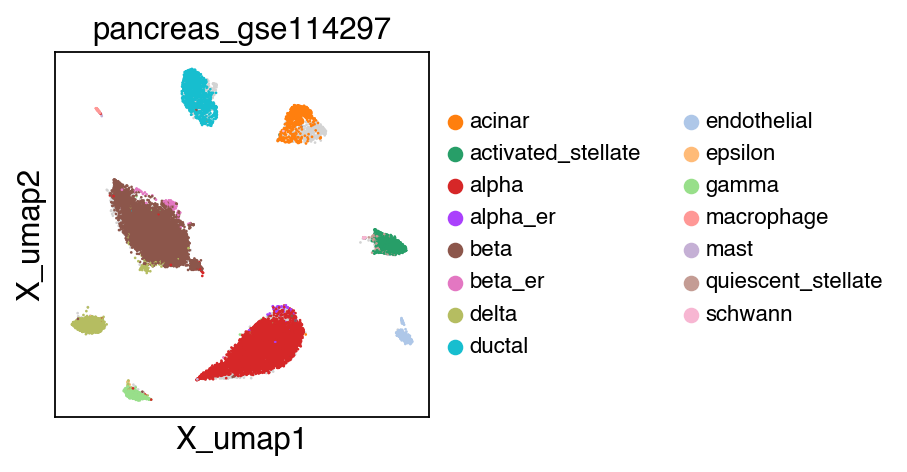

In [24]:
sc.pl.umap(adata[adata.obs.batch.isin(['pancreas_gse114297','pancreas_gse81547','pancreas_gse83139'])],color='batch',legend_fontsize=10)
embedding(adata[adata.obs.batch.isin(['pancreas_gse114297','pancreas_gse81547','pancreas_gse83139'])],legend_fontsize=10)

The projection results is stored as `adata.h5ad` in the output directory assigned by `outdir` parameter in scCobra function. 

## Label transfer

We can also use scCobra to transfer data from one dataset to another. Here, we demonstrate data transfer between two scRNA-seq datasets by transferring the cell type label from the `adata_ref` and the `adata_query`.

In [25]:
adata_query=adata[adata.obs.projection=='query']
adata_query

View of AnnData object with n_obs × n_vars = 23744 × 2000
    obs: 'batch', 'celltype', 'disease', 'donor', 'library', 'protocol', 'n_genes', 'leiden', 'projection'
    var: 'n_cells-reference', 'highly_variable-reference', 'means-reference', 'dispersions-reference', 'dispersions_norm-reference', 'highly_variable_nbatches-reference', 'highly_variable_intersection-reference'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

In [26]:
adata_ref=adata[adata.obs.projection=='reference']
adata_ref

View of AnnData object with n_obs × n_vars = 15277 × 2000
    obs: 'batch', 'celltype', 'disease', 'donor', 'library', 'protocol', 'n_genes', 'leiden', 'projection'
    var: 'n_cells-reference', 'highly_variable-reference', 'means-reference', 'dispersions-reference', 'dispersions_norm-reference', 'highly_variable_nbatches-reference', 'highly_variable_intersection-reference'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

In [27]:
adata_query.obs['celltype_transfer']=label_transfer(adata_ref, adata_query, rep='latent', label='celltype')

Trying to set attribute `.obs` of view, copying.


... storing 'celltype_transfer' as categorical


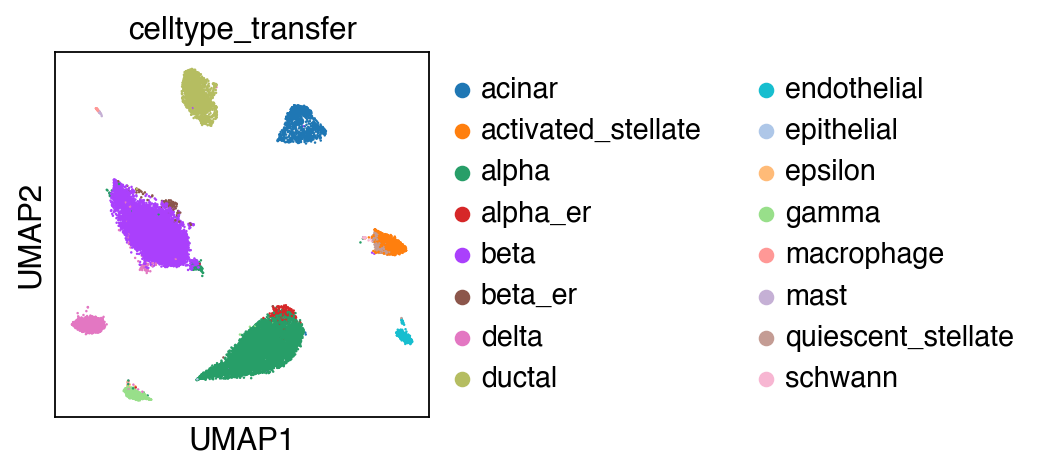

In [28]:
sc.pl.umap(adata_query,color=['celltype_transfer'])

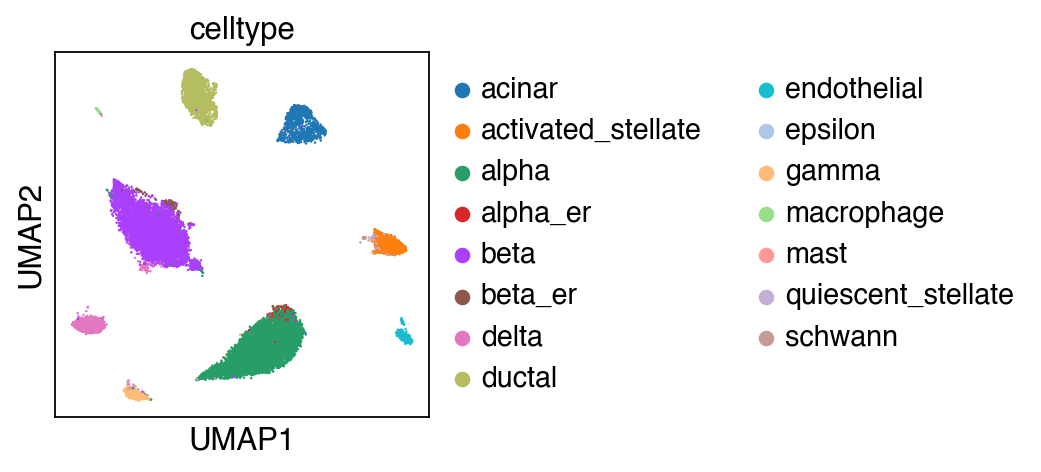

In [29]:
sc.pl.umap(adata_query,color=['celltype'])

Let us first focus on cell types that are conserved with the reference.

In [30]:
obs_query = adata_query.obs
conserved_categories = obs_query.celltype.cat.categories.intersection(obs_query.celltype_transfer.cat.categories)  # intersected categories
obs_query_conserved = obs_query.loc[obs_query.celltype.isin(conserved_categories) & obs_query.celltype_transfer.isin(conserved_categories)]  # intersect categories
obs_query_conserved.celltype.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
obs_query_conserved.celltype_transfer.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
obs_query_conserved.celltype_transfer.cat.reorder_categories(obs_query_conserved.celltype.cat.categories, inplace=True)  # fix category ordering
pd.crosstab(obs_query_conserved.celltype, obs_query_conserved.celltype_transfer)

celltype_transfer   acinar  activated_stellate  alpha  alpha_er  beta  \
celltype                                                                
acinar                1346                   0      3         0     3   
activated_stellate       0                1033      0         0     2   
alpha                    2                   0   7527        83    13   
alpha_er                 0                   0    159       105     2   
beta                     3                   0    119         4  8683   
beta_er                  0                   0      0         0    41   
delta                    1                   0      8         0    34   
ductal                   2                   0      3         0     2   
endothelial              0                   1      0         0     1   
epsilon                  1                   0      0         0     0   
gamma                    0                   0      7         2     3   
macrophage               0                   0      0         0     0   
mast                     1                   0      0         0     1   
quiescent_stellate       0                  53      0         0     2   
schwann                  1                   0      2         0     0   

celltype_transfer   beta_er  delta  ductal  endothelial  epsilon  gamma  \
celltype                                                                  
acinar                    0      0       2            0        0      0   
activated_stellate        0      0       0            0        0      0   
alpha                     0      3       0            0        0     11   
alpha_er                  1      0       0            0        0      0   
beta                     34     17       1            0        0      3   
beta_er                  56      0       1            0        0      0   
delta                     0   1099       0            0        1      6   
ductal                    0      3    1889            0        0      0   
endothelial               0      1       0          456        0      0   
epsilon                   0      3       0            0       10      3   
gamma                     0      1       0            0        2    578   
macrophage                0      0       0            0        0      0   
mast                      0      0       0            0        0      0   
quiescent_stellate        0      0       0            0        0      0   
schwann                   1      0       0            0        0      0   

celltype_transfer   macrophage  mast  quiescent_stellate  schwann  
celltype                                                           
acinar                       0     0                   1        0  
activated_stellate           0     0                 119        1  
alpha                        0     1                   0        0  
alpha_er                     0     0                   0        0  
beta                         0     0                   0        0  
beta_er                      0     0                   0        0  
delta                        0     0                   0        0  
ductal                       0     0                   0        0  
endothelial                  0     0                   1        0  
epsilon                      0     0                   0        0  
gamma                        0     0                   0        0  
macrophage                  58    14                   0        0  
mast                         3     6                   0        0  
quiescent_stellate           0     0                  68        1  
schwann                      0     0                   0       34

Let us now move on to look at all cell types.

In [31]:
pd.crosstab(adata_query.obs.celltype, adata_query.obs.celltype_transfer)

celltype_transfer   acinar  activated_stellate  alpha  alpha_er  beta  \
celltype                                                                
acinar                1346                   0      3         0     3   
activated_stellate       0                1033      0         0     2   
alpha                    2                   0   7527        83    13   
alpha_er                 0                   0    159       105     2   
beta                     3                   0    119         4  8683   
beta_er                  0                   0      0         0    41   
delta                    1                   0      8         0    34   
ductal                   2                   0      3         0     2   
endothelial              0                   1      0         0     1   
epsilon                  1                   0      0         0     0   
gamma                    0                   0      7         2     3   
macrophage               0                   0      0         0     0   
mast                     1                   0      0         0     1   
quiescent_stellate       0                  53      0         0     2   
schwann                  1                   0      2         0     0   

celltype_transfer   beta_er  delta  ductal  endothelial  epithelial  epsilon  \
celltype                                                                       
acinar                    0      0       2            0           0        0   
activated_stellate        0      0       0            0           0        0   
alpha                     0      3       0            0           1        0   
alpha_er                  1      0       0            0           0        0   
beta                     34     17       1            0           0        0   
beta_er                  56      0       1            0           0        0   
delta                     0   1099       0            0           0        1   
ductal                    0      3    1889            0           0        0   
endothelial               0      1       0          456           0        0   
epsilon                   0      3       0            0           0       10   
gamma                     0      1       0            0           0        2   
macrophage                0      0       0            0           0        0   
mast                      0      0       0            0           1        0   
quiescent_stellate        0      0       0            0           0        0   
schwann                   1      0       0            0           0        0   

celltype_transfer   gamma  macrophage  mast  quiescent_stellate  schwann  
celltype                                                                  
acinar                  0           0     0                   1        0  
activated_stellate      0           0     0                 119        1  
alpha                  11           0     1                   0        0  
alpha_er                0           0     0                   0        0  
beta                    3           0     0                   0        0  
beta_er                 0           0     0                   0        0  
delta                   6           0     0                   0        0  
ductal                  0           0     0                   0        0  
endothelial             0           0     0                   1        0  
epsilon                 3           0     0                   0        0  
gamma                 578           0     0                   0        0  
macrophage              0          58    14                   0        0  
mast                    0           3     6                   0        0  
quiescent_stellate      0           0     0                  68        1  
schwann                 0           0     0                   0       34